# Input data

## Reading Data

In [ ]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 8.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle5 as pickle
from pathlib import Path
from google.colab import drive

In [ ]:
drive_dir = Path('drive')
drive.mount(str(drive_dir.resolve()), force_remount=True)

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/mumin-small/tweet.pickle', 'rb') as f:
    tweet_df = pd.DataFrame(pickle.load(f))

tweet_df.dropna(inplace=True)

with open('/content/drive/MyDrive/mumin-small/reply.pickle', 'rb') as f:
    reply_df = pd.DataFrame(pickle.load(f))

reply_df.dropna(inplace=True)

with open('/content/drive/MyDrive/mumin-small/text_emb_sml_tweet.pkl', 'rb') as f:
    tweet_temb_df = pd.DataFrame(pickle.load(f))
    
with open('/content/drive/MyDrive/mumin-small/multilingual_emb_sml_tweet.pkl', 'rb') as f:
    tweet_memb_df = pd.DataFrame(pickle.load(f))

    
with open('/content/drive/MyDrive/mumin-small/text_emb_sml_reply.pkl', 'rb') as f:
    reply_temb_df = pd.DataFrame(pickle.load(f))
    
with open('/content/drive/MyDrive/mumin-small/multilingual_emb_sml_reply.pkl', 'rb') as f:
    reply_memb_df = pd.DataFrame(pickle.load(f))

    
with open('/content/drive/MyDrive/mumin-small/tweet_discusses_claim.pickle', 'rb') as f:
    tweet_discusses_claim_df = pd.DataFrame(pickle.load(f))
        
with open('/content/drive/MyDrive/mumin-small/claim.pickle', 'rb') as f:
    claim_df = pd.DataFrame(pickle.load(f))

with open('/content/drive/MyDrive/mumin-small/reply_reply_to_tweet.pickle', 'rb') as f:
    reply_reply_to_tweet_df = pd.DataFrame(pickle.load(f))


tweet_claim_df = (tweet_df
                  .merge(tweet_discusses_claim_df, left_index=True, right_on='src')
                          .merge(claim_df, left_on='tgt', right_index=True)
                          .reset_index(drop=True))


In [ ]:
tweet_claim_df['mbert_emb'] = tweet_memb_df['mbert_emb']

In [ ]:
# Split up the data
train = tweet_claim_df.query('train_mask == True')
val = tweet_claim_df.query('val_mask == True')
test = tweet_claim_df.query('test_mask == True')

# Extract the tweet embeddings
X1 = np.array(tweet_claim_df.text_emb.tolist())
X2 = np.array(tweet_claim_df.mbert_emb.tolist())

X_train1 = np.array(train.text_emb.tolist())
X_val1 = np.array(val.text_emb.tolist())
X_test1 = np.array(test.text_emb.tolist())

X_train2 = np.array(train.mbert_emb.tolist())
X_val2 = np.array(val.mbert_emb.tolist())
X_test2 = np.array(test.mbert_emb.tolist())

# Extract the labels
y = np.array(tweet_claim_df.label.tolist())

y_train = np.array(train.label.tolist())
y_val = np.array(val.label.tolist())
y_test = np.array(test.label.tolist())

y = np.array([0 if i == 'misinformation' else 1 for i in y])
y_train = np.array([0 if i == 'misinformation' else 1 for i in y_train])
y_val = np.array([0 if i == 'misinformation' else 1 for i in y_val])
y_test = np.array([0 if i == 'misinformation' else 1 for i in y_test])
# Sanity check the dimensions
X_train1.shape, y_train.shape, X_val1.shape, y_val.shape, X_test1.shape, y_test.shape

((3665, 768), (3665,), (662, 768), (662,), (563, 768), (563,))

## UMAP visualization

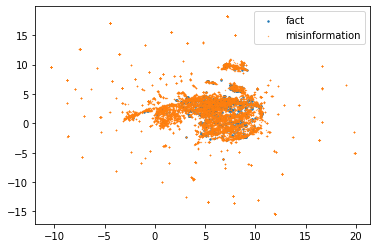

In [ ]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(X1)
embedding11 = []
for i in range(len(y)):
    if y[i] == 1:
        embedding11.append(embedding[i][0]) 
embedding12 = []
for i in range(len(y)):
    if y[i] == 1:
        embedding12.append(embedding[i][1]) 
embedding21 = []
for i in range(len(y)):
    if y[i] == 0:
        embedding21.append(embedding[i][0]) 
embedding22 = []
for i in range(len(y)):
    if y[i] == 0:
        embedding22.append(embedding[i][1]) 
plt.scatter(embedding11, embedding12, s = 2)
plt.scatter(embedding21, embedding22, s = 0.1)
plt.legend(['fact', 'misinformation'])
plt.show()

D:\anaconda\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


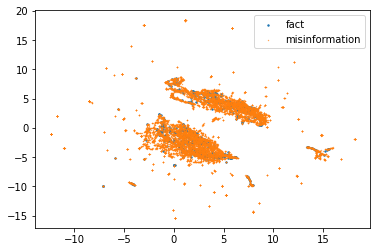

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X2)
embedding11 = []
for i in range(len(y)):
    if y[i] == 1:
        embedding11.append(embedding[i][0]) 
embedding12 = []
for i in range(len(y)):
    if y[i] == 1:
        embedding12.append(embedding[i][1]) 
embedding21 = []
for i in range(len(y)):
    if y[i] == 0:
        embedding21.append(embedding[i][0]) 
embedding22 = []
for i in range(len(y)):
    if y[i] == 0:
        embedding22.append(embedding[i][1]) 
plt.scatter(embedding11, embedding12, s = 2)
plt.scatter(embedding21, embedding22, s = 0.1)
plt.legend(['fact', 'misinformation'])
plt.show()

## Over-sampling

In [ ]:
print(np.count_nonzero(y_train == 1))
print(np.count_nonzero(y_train == 0))

324
3485


In [ ]:
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 

over = RandomOverSampler(sampling_strategy=0.3) 
under = RandomUnderSampler(sampling_strategy=0.5) 
 
from imblearn.pipeline import Pipeline 
 
steps = [('o', over), ('u', under)] 
pipeline = Pipeline(steps=steps) 
 
X_resample1, y_resample = pipeline.fit_resample(X_train1, y_train)
X_resample2, y_resample = pipeline.fit_resample(X_train2, y_train)

# Dimensional Reduction

## PCA 

In [ ]:
from sklearn.decomposition import PCA
pca1 = PCA(n_components=100)
pca2 = PCA(n_components=100)
pca1.fit(X1)
pca2.fit(X2)

PCA(n_components=100)

Text(0.5, 1.0, 'mbert embedded')

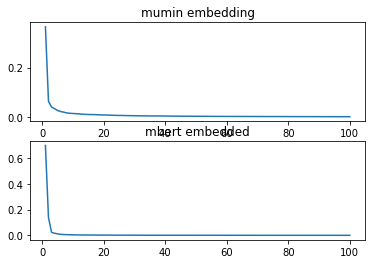

In [ ]:
plt.subplot(2,1,1)
plt.plot([i for i in range(1,101)], pca1.explained_variance_ratio_)
plt.title('mumin embedding')
plt.subplot(2,1,2)
plt.plot([i for i in range(1,101)], pca2.explained_variance_ratio_)
plt.title('mbert embedded')

Text(0.5, 1.0, 'mbert embedded')

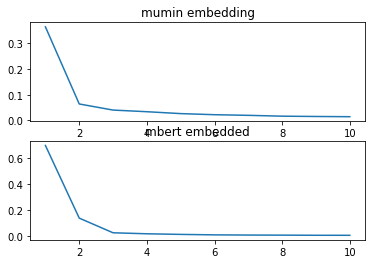

In [ ]:
plt.subplot(2,1,1)
plt.plot([i for i in range(1,11)], pca1.explained_variance_ratio_[:10])
plt.title('mumin embedding')
plt.subplot(2,1,2)
plt.plot([i for i in range(1,11)], pca2.explained_variance_ratio_[:10])
plt.title('mbert embedded')

In [ ]:
print(pca1.explained_variance_ratio_[:10])
print(pca2.explained_variance_ratio_[:10])

[0.36502525 0.06368149 0.03983722 0.03341469 0.0260222  0.02177053
 0.01926548 0.01600554 0.01480273 0.01392931]
[0.6980761  0.13685295 0.02359081 0.015894   0.01113504 0.00753258
 0.0060602  0.00540013 0.00437654 0.00409866]


In [ ]:
sum(pca1.explained_variance_ratio_[:64])

0.8798892602790147

In [ ]:
sum(pca2.explained_variance_ratio_[:4])

0.8744138963520527

In [ ]:
pca1 = PCA(n_components=64)
pca2 = PCA(n_components=4)
pca1.fit(X1)
pca2.fit(X2)
X_train1p = pca1.transform(X_train1)
X_test1p = pca1.transform(X_test1)
X_val1p = pca1.transform(X_val1)
X_train2p = pca2.transform(X_train2)
X_test2p = pca2.transform(X_test2)
X_val2p = pca2.transform(X_val2)

## Autoencoder

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
tf.debugging.set_log_device_placement(False)

In [ ]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [ ]:
def dnn(size):
    return tf.keras.Sequential([
        layers.Input(shape=(size,)),
        #layers.Dense(768, activation='tanh'),
        #layers.Dropout(0.2),
        #layers.Dense(1024, activation='tanh'),
        #layers.Dropout(0.2),
        layers.Dense(1024, activation='tanh'),
        #layers.Dropout(0.2),
        layers.Dense(768, activation='tanh'),
        #layers.Dropout(0.2),
        layers.Dense(128, activation='tanh'),
        #layers.Dropout(0.2),
        layers.Dense(16, activation='tanh'),
        layers.Dense(1, activation='softmax')
    ])
dnnclassifier = dnn(768)
dnnclassifier.compile(optimizer='adam',
                      loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics = metrics
                     )

In [ ]:
dnnclassifier.fit(X_train1, y_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_val1, y_val))

Epoch 1/10
331/331 [==============================] - 5s 13ms/step - loss: 0.2342 - accuracy: 0.0558 - precision: 0.0558 - recall: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.0195 - val_precision: 0.0195 - val_recall: 1.0000
Epoch 2/10
331/331 [==============================] - 4s 11ms/step - loss: 0.2314 - accuracy: 0.0616 - precision: 0.0616 - recall: 1.0000 - val_loss: 0.1114 - val_accuracy: 0.0195 - val_precision: 0.0195 - val_recall: 1.0000
Epoch 3/10
331/331 [==============================] - 3s 10ms/step - loss: 0.2315 - accuracy: 0.0616 - precision: 0.0616 - recall: 1.0000 - val_loss: 0.1122 - val_accuracy: 0.0195 - val_precision: 0.0195 - val_recall: 1.0000
Epoch 4/10
331/331 [==============================] - 3s 10ms/step - loss: 0.2316 - accuracy: 0.0616 - precision: 0.0616 - recall: 1.0000 - val_loss: 0.1177 - val_accuracy: 0.0195 - val_precision: 0.0195 - val_recall: 1.0000
Epoch 5/10
331/331 [==============================] - 3s 10ms/step - loss: 0.2315 - accuracy: 0.0616

In [ ]:
dpred1 = dnnclassifier.predict(X_test1)

53/53 [==============================] - 0s 4ms/step


In [ ]:
dpred1 = [0 if i[0] >= 0.5 else 1 for i in dpred1]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dpred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1592
           1       0.05      1.00      0.09        76

    accuracy                           0.05      1668
   macro avg       0.02      0.50      0.04      1668
weighted avg       0.00      0.05      0.00      1668



D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
class Autoencoder1(Model):
    def __init__(self, latent_dim):
        super(Autoencoder1, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(768,)),
            layers.Dense(256, activation='tanh'),
            layers.Dense(latent_dim, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(768, activation='tanh')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Autoencoder2(Model):
    def __init__(self, latent_dim):
        super(Autoencoder2, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(768,)),
            layers.Dense(256, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(16, activation='tanh'),
            layers.Dense(latent_dim, activation='tanh')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(256, activation='tanh'),
            layers.Dense(768, activation='tanh')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
autoencoder1 = Autoencoder1(64)
autoencoder2 = Autoencoder2(2)

autoencoder1.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder2.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder1.fit(X1, X1,
                epochs=10,
                shuffle=True,
                validation_data=(X1, X1))

autoencoder2.fit(X2, X2,
                epochs=10,
                shuffle=True,
                validation_data=(X2, X2))

Epoch 1/10
153/153 [==============================] - 2s 9ms/step - loss: 0.0050 - val_loss: 1.1734e-04
Epoch 2/10
153/153 [==============================] - 1s 7ms/step - loss: 1.1726e-04 - val_loss: 1.1588e-04
Epoch 3/10
153/153 [==============================] - 1s 7ms/step - loss: 1.1402e-04 - val_loss: 1.1154e-04
Epoch 4/10
153/153 [==============================] - 1s 7ms/step - loss: 1.0732e-04 - val_loss: 9.9186e-05
Epoch 5/10
153/153 [==============================] - 1s 7ms/step - loss: 9.3669e-05 - val_loss: 8.7373e-05
Epoch 6/10
153/153 [==============================] - 1s 8ms/step - loss: 8.4096e-05 - val_loss: 8.0449e-05
Epoch 7/10
153/153 [==============================] - 1s 8ms/step - loss: 8.1882e-05 - val_loss: 7.8104e-05
Epoch 8/10
153/153 [==============================] - 1s 9ms/step - loss: 7.9524e-05 - val_loss: 7.7300e-05
Epoch 9/10
153/153 [==============================] - 1s 8ms/step - loss: 7.9539e-05 - val_loss: 7.8771e-05
Epoch 10/10
153/153 [===========

In [ ]:
encoder1 = autoencoder1.encoder
encoder2 = autoencoder2.encoder

In [ ]:
X_train1a = encoder1.predict(X_train1)
X_test1a = encoder1.predict(X_test1)
X_val1a = encoder1.predict(X_val1)
X_train2a = encoder2.predict(X_train2)
X_test2a = encoder2.predict(X_test2)
X_val2a = encoder2.predict(X_val2)

21/21 [==============================] - 0s 2ms/step


# Logistic Regression Test

## Resampled Data

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from time import time

time1 = time()
lr1 = LogisticRegressionCV(cv=5, max_iter=10000).fit(X_resample1, y_resample.reshape(-1,1))
time2 = time()
lr2 = LogisticRegressionCV(cv=5, max_iter=10000).fit(X_resample2, y_resample.reshape(-1,1))
time3 = time()

train_preds1 = lr1.predict(X_train1)
val_preds1 = lr1.predict(X_val1)
test_preds1 = lr1.predict(X_test1)

train_preds2 = lr2.predict(X_train2)
val_preds2 = lr2.predict(X_val2)
test_preds2 = lr2.predict(X_test2)

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

train_scores2 = f1_score(y_train, train_preds2, average=None)
val_scores2 = f1_score(y_val, val_preds2, average=None)
test_scores2 = f1_score(y_test, test_preds2, average=None)


print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

print()
print('---------------------------------------------------------------------------')
print()

print('*** Training scores ***')
print(f'Misinformation F1: {100 * train_scores2[1]:.2f}%')
print(f'Factual F1: {100 * train_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores2.mean():.2f}%\n')

print('*** Validation scores ***')
print(f'Misinformation F1: {100 * val_scores2[1]:.2f}%')
print(f'Factual F1: {100 * val_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores2.mean():.2f}%\n')

print('*** Test scores ***')
print(f'Misinformation F1: {100 * test_scores2[1]:.2f}%')
print(f'Factual F1: {100 * test_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores2.mean():.2f}%')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Training scores 1 ***
Misinformation F1: 75.62%
Factual F1: 97.00%
Macro-average F1: 86.31%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 88.46%
Macro-average F1: 44.23%

*** Test scores 1 ***
Misinformation F1: 17.86%
Factual F1: 90.93%
Macro-average F1: 54.39%

---------------------------------------------------------------------------

*** Training scores ***
Misinformation F1: 79.10%
Factual F1: 97.44%
Macro-average F1: 88.27%

*** Validation scores ***
Misinformation F1: 5.93%
Factual F1: 89.32%
Macro-average F1: 47.62%

*** Test scores ***
Misinformation F1: 12.84%
Factual F1: 90.66%
Macro-average F1: 51.75%


In [ ]:

print('****MuMiN-Embedded training time****: ',end = '')
print(time2-time1)
print('****MBERT-Embedded training time****: ',end = '')
print(time3-time2)

****MuMiN-Embedded training time****: 49.80716633796692
****MBERT-Embedded training time****: 61.73518252372742


## Original Data

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

lr1 = LogisticRegressionCV(cv=5, max_iter=10000).fit(X_train1, y_train.reshape(-1,1))
lr2 = LogisticRegressionCV(cv=5, max_iter=10000).fit(X_train2, y_train.reshape(-1,1))

train_preds1 = lr1.predict(X_train1)
val_preds1 = lr1.predict(X_val1)
test_preds1 = lr1.predict(X_test1)

train_preds2 = lr2.predict(X_train2)
val_preds2 = lr2.predict(X_val2)
test_preds2 = lr2.predict(X_test2)

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

train_scores2 = f1_score(y_train, train_preds2, average=None)
val_scores2 = f1_score(y_val, val_preds2, average=None)
test_scores2 = f1_score(y_test, test_preds2, average=None)


print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

print()
print('---------------------------------------------------------------------------')
print()

print('*** Training scores ***')
print(f'Misinformation F1: {100 * train_scores2[1]:.2f}%')
print(f'Factual F1: {100 * train_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores2.mean():.2f}%\n')

print('*** Validation scores ***')
print(f'Misinformation F1: {100 * val_scores2[1]:.2f}%')
print(f'Factual F1: {100 * val_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores2.mean():.2f}%\n')

print('*** Test scores ***')
print(f'Misinformation F1: {100 * test_scores2[1]:.2f}%')
print(f'Factual F1: {100 * test_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores2.mean():.2f}%')

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Training scores 1 ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores 1 ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%

---------------------------------------------------------------------------

*** Training scores ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%


## Dimensional Reduced Data

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

lr1 = LogisticRegressionCV(cv=5, max_iter=1000).fit(X_train1p, y_train.reshape(-1,1))
lr2 = LogisticRegressionCV(cv=5, max_iter=1000).fit(X_train2p, y_train.reshape(-1,1))

train_preds1 = lr1.predict(X_train1p)
val_preds1 = lr1.predict(X_val1p)
test_preds1 = lr1.predict(X_test1p)

train_preds2 = lr2.predict(X_train2p)
val_preds2 = lr2.predict(X_val2p)
test_preds2 = lr2.predict(X_test2p)

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

train_scores2 = f1_score(y_train, train_preds2, average=None)
val_scores2 = f1_score(y_val, val_preds2, average=None)
test_scores2 = f1_score(y_test, test_preds2, average=None)


print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

print()
print('---------------------------------------------------------------------------')
print()

print('*** Training scores ***')
print(f'Misinformation F1: {100 * train_scores2[1]:.2f}%')
print(f'Factual F1: {100 * train_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores2.mean():.2f}%\n')

print('*** Validation scores ***')
print(f'Misinformation F1: {100 * val_scores2[1]:.2f}%')
print(f'Factual F1: {100 * val_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores2.mean():.2f}%\n')

print('*** Test scores ***')
print(f'Misinformation F1: {100 * test_scores2[1]:.2f}%')
print(f'Factual F1: {100 * test_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores2.mean():.2f}%')

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Training scores 1 ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores 1 ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%

---------------------------------------------------------------------------

*** Training scores ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

lr1 = LogisticRegressionCV(cv=5, max_iter=1000).fit(X_train1a, y_train.reshape(-1,1))
lr2 = LogisticRegressionCV(cv=5, max_iter=1000).fit(X_train2a, y_train.reshape(-1,1))

train_preds1 = lr1.predict(X_train1a)
val_preds1 = lr1.predict(X_val1a)
test_preds1 = lr1.predict(X_test1a)

train_preds2 = lr2.predict(X_train2a)
val_preds2 = lr2.predict(X_val2a)
test_preds2 = lr2.predict(X_test2a)

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

train_scores2 = f1_score(y_train, train_preds2, average=None)
val_scores2 = f1_score(y_val, val_preds2, average=None)
test_scores2 = f1_score(y_test, test_preds2, average=None)


print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

print()
print('---------------------------------------------------------------------------')
print()

print('*** Training scores ***')
print(f'Misinformation F1: {100 * train_scores2[1]:.2f}%')
print(f'Factual F1: {100 * train_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores2.mean():.2f}%\n')

print('*** Validation scores ***')
print(f'Misinformation F1: {100 * val_scores2[1]:.2f}%')
print(f'Factual F1: {100 * val_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores2.mean():.2f}%\n')

print('*** Test scores ***')
print(f'Misinformation F1: {100 * test_scores2[1]:.2f}%')
print(f'Factual F1: {100 * test_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores2.mean():.2f}%')

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Training scores 1 ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores 1 ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%

---------------------------------------------------------------------------

*** Training scores ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%


D:\anaconda\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# XGBoost Test

## MuMiN Test

In [ ]:
from sklearn.model_selection import cross_validate, GridSearchCV   #Additional     scklearn functions
from sklearn import metrics

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=20,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    tree_method='gpu_hist',
    gpu_id=0).fit(X_smote1, y_smote.reshape(-1,1))

train_preds1 = xgb1.predict(X_train1)
val_preds1 = xgb1.predict(X_val1)
test_preds1 = xgb1.predict(X_test1)

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[03:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
*** Training scores 1 ***
Misinformation F1: 52.68%
Factual F1: 97.06%
Macro-average F1: 74.87%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 99.24%
Macro-average F1: 49.62%

*** Test scores 1 ***
Misinformation F1: 8.70%
Factual F1: 98.10%
Macro-average F1: 53.40%


## MuMiN  optimization

In [ ]:
t = 0
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
time1 = time()
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test1, scoring='f1', cv=5)
gsearch1.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch1.cv_results_

{'mean_fit_time': array([0.58142824, 0.57553148, 0.57505283, 0.84180326, 0.78563385,
        0.75513902, 1.11399803, 0.95076108, 0.87983856, 1.25295205,
        1.03212123, 0.93366833]),
 'std_fit_time': array([0.00737313, 0.0010546 , 0.00140332, 0.00429548, 0.00501429,
        0.00377651, 0.00282126, 0.00175889, 0.00486119, 0.0092532 ,
        0.00529161, 0.00359836]),
 'mean_score_time': array([0.01119952, 0.01133599, 0.01114192, 0.01630697, 0.01521873,
        0.01566019, 0.0182826 , 0.0176199 , 0.01764641, 0.01959872,
        0.0185257 , 0.01800022]),
 'std_score_time': array([8.51355857e-05, 3.28846403e-04, 9.81658903e-05, 9.43420379e-04,
        2.99231065e-04, 8.77689970e-04, 1.17862957e-04, 1.55287158e-04,
        8.38739857e-04, 2.13509502e-04, 1.50482328e-04, 2.67630121e-04]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
 

In [ ]:
param_test2 = {
 'min_child_weight':[0.5,0.8,1]
}
time1 = time()
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test2, scoring='f1', cv=5)
gsearch2.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch2.cv_results_


{'mean_fit_time': array([1.23147268, 1.14880395, 1.10962982]),
 'std_fit_time': array([0.0076673 , 0.00430254, 0.00332533]),
 'mean_score_time': array([0.01914506, 0.01834202, 0.01824274]),
 'std_score_time': array([0.00056719, 0.00015372, 0.00012443]),
 'param_min_child_weight': masked_array(data=[0.5, 0.8, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 0.5},
  {'min_child_weight': 0.8},
  {'min_child_weight': 1}],
 'split0_test_score': array([0.95140665, 0.95165394, 0.956743  ]),
 'split1_test_score': array([0.95238095, 0.95717884, 0.95696203]),
 'split2_test_score': array([0.98522167, 0.97560976, 0.98280098]),
 'split3_test_score': array([0.97810219, 0.9804878 , 0.9804878 ]),
 'split4_test_score': array([0.9950495 , 0.9950495 , 0.99259259]),
 'mean_test_score': array([0.97243219, 0.97199597, 0.97391728]),
 'std_test_score': array([0.0176147 , 0.01581127, 0.0145141 ]),
 'rank_test_score': array([2, 3,

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
time1 = time()
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test3, scoring='f1', cv=5)
gsearch3.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch3.cv_results_

{'mean_fit_time': array([1.11497397, 1.11143236, 1.11052303, 1.11009498, 1.11180682]),
 'std_fit_time': array([0.00253463, 0.00375154, 0.00329436, 0.00462837, 0.0018003 ]),
 'mean_score_time': array([0.01847215, 0.01819677, 0.01821141, 0.01857653, 0.01824985]),
 'std_score_time': array([5.66511270e-04, 1.71465192e-04, 1.00276644e-04, 6.77412942e-04,
        9.67348062e-05]),
 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.0},
  {'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.3},
  {'gamma': 0.4}],
 'split0_test_score': array([0.956743, 0.956743, 0.956743, 0.956743, 0.956743]),
 'split1_test_score': array([0.95696203, 0.95696203, 0.95696203, 0.95696203, 0.95696203]),
 'split2_test_score': array([0.98280098, 0.98280098, 0.98280098, 0.98280098, 0.98280098]),
 'split3_test_score': array([0.9804878, 0.9804878, 0.9804878, 0.9804878, 0.9804878]),
 's

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
time1 = time()
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test4, scoring='f1', cv=5)
gsearch4.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch4.cv_results_

{'mean_fit_time': array([1.01598644, 1.03360667, 1.05255537, 1.06826553, 1.03736329,
        1.0651228 , 1.08519759, 1.09339113, 1.06919208, 1.08513899,
        1.10874329, 1.12739205, 1.10461159, 1.13236666, 1.14998484,
        1.16355219]),
 'std_fit_time': array([0.00268934, 0.00982941, 0.00453675, 0.00621128, 0.0052664 ,
        0.00604263, 0.00338314, 0.0052907 , 0.00640628, 0.00903158,
        0.00339267, 0.00904854, 0.00467155, 0.0097439 , 0.0035051 ,
        0.00809792]),
 'mean_score_time': array([0.0182766 , 0.01827612, 0.0182766 , 0.01841216, 0.0183527 ,
        0.01835446, 0.01840825, 0.01832628, 0.01822491, 0.01834316,
        0.01832738, 0.01820588, 0.01813374, 0.01816802, 0.01831579,
        0.01815362]),
 'std_score_time': array([8.13424096e-05, 1.12033862e-04, 1.94425730e-04, 2.97879886e-04,
        3.89623446e-04, 2.05055247e-04, 4.26007326e-04, 2.42419669e-04,
        1.44054265e-04, 1.47623224e-04, 8.68739986e-05, 9.98801419e-05,
        1.11908774e-04, 9.50859685e-

In [ ]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
time1 = time()
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test5, scoring='f1', cv=5)
gsearch5.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch5.cv_results_

{'mean_fit_time': array([1.11949644, 1.11992936, 1.12974133, 1.19909253, 0.52897296]),
 'std_fit_time': array([0.00654364, 0.00250399, 0.00596163, 0.00608122, 0.00317643]),
 'mean_score_time': array([0.01830997, 0.01817322, 0.01833801, 0.01849575, 0.00925789]),
 'std_score_time': array([0.00019921, 0.00019882, 0.00017051, 0.00011143, 0.00104876]),
 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_alpha': 1e-05},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.1},
  {'reg_alpha': 1},
  {'reg_alpha': 100}],
 'split0_test_score': array([0.956743  , 0.95384615, 0.94871795, 0.95652174, 0.45112782]),
 'split1_test_score': array([0.95696203, 0.95696203, 0.95696203, 0.95431472, 0.25531915]),
 'split2_test_score': array([0.98280098, 0.97799511, 0.98039216, 0.97799511, 0.32258065]),
 'split3_test_score': array([0.9804878 , 0.9804878 , 0.98288509, 0.9804878 , 0.39

In [ ]:
param_test6 = {
 'learning_rate':[0.01, 0.05, 0.1]
}
time1 = time()
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0,
                                                  reg_alpha=1e-5), 
                        param_grid = param_test6, scoring='f1', cv=5)
gsearch6.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch6.cv_results_

{'mean_fit_time': array([1.56438723, 1.33324518, 1.1146059 ]),
 'std_fit_time': array([0.01838875, 0.00538715, 0.00461874]),
 'mean_score_time': array([0.01999621, 0.01941404, 0.01817899]),
 'std_score_time': array([2.70245725e-04, 1.35165260e-04, 6.46381569e-05]),
 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01},
  {'learning_rate': 0.05},
  {'learning_rate': 0.1}],
 'split0_test_score': array([0.91623037, 0.94656489, 0.956743  ]),
 'split1_test_score': array([0.93059126, 0.95696203, 0.95696203]),
 'split2_test_score': array([0.96551724, 0.98039216, 0.98280098]),
 'split3_test_score': array([0.95049505, 0.97810219, 0.9804878 ]),
 'split4_test_score': array([0.95781638, 0.99259259, 0.99259259]),
 'mean_test_score': array([0.94413006, 0.97092277, 0.97391728]),
 'std_test_score': array([0.018149  , 0.01672724, 0.0145141 ]),
 'rank_test_score': arra

In [ ]:
param_test7 = {
 'learning_rate':[0.1, 0.15]
}
time1 = time()
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0,
                                                  reg_alpha=1e-5), 
                        param_grid = param_test7, scoring='f1', cv=5)
gsearch7.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch7.cv_results_

{'mean_fit_time': array([1.11715641, 0.98146954]),
 'std_fit_time': array([0.00301002, 0.00486313]),
 'mean_score_time': array([0.01825032, 0.01671119]),
 'std_score_time': array([9.89793346e-05, 1.01054766e-04]),
 'param_learning_rate': masked_array(data=[0.1, 0.15],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1}, {'learning_rate': 0.15}],
 'split0_test_score': array([0.956743  , 0.94897959]),
 'split1_test_score': array([0.95696203, 0.95696203]),
 'split2_test_score': array([0.98280098, 0.97323601]),
 'split3_test_score': array([0.9804878 , 0.98288509]),
 'split4_test_score': array([0.99259259, 0.98771499]),
 'mean_test_score': array([0.97391728, 0.96995554]),
 'std_test_score': array([0.0145141 , 0.01484692]),
 'rank_test_score': array([1, 2], dtype=int32)}

In [ ]:
param_test8 = {
 'n_estimators':[i for i in range(100, 210, 10)]
}
time1 = time()
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0,
                                                  reg_alpha=1e-5), 
                        param_grid = param_test8, scoring='f1', cv=5)
gsearch8.fit(X_resample1, y_resample)
time2 = time()
t += time2-time1
gsearch8.cv_results_

{'mean_fit_time': array([0.94635234, 0.98703194, 1.03100705, 1.07464943, 1.11562729,
        1.15622058, 1.1937943 , 1.2328526 , 1.27577271, 1.30725141,
        1.33869767]),
 'std_fit_time': array([0.00846709, 0.0023872 , 0.00351924, 0.00442624, 0.00352292,
        0.00389181, 0.00465069, 0.00481014, 0.01117949, 0.00585752,
        0.00454597]),
 'mean_score_time': array([0.01498241, 0.01586776, 0.01661243, 0.01742835, 0.01827831,
        0.01897526, 0.01960921, 0.02024484, 0.02116208, 0.02164192,
        0.02226739]),
 'std_score_time': array([1.21921993e-04, 6.40201434e-05, 1.04516962e-04, 1.29374577e-04,
        1.71407233e-04, 2.15310115e-04, 1.23787514e-04, 1.78103434e-04,
        3.46326779e-04, 1.77426448e-04, 2.09049315e-04]),
 'param_n_estimators': masked_array(data=[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             d

In [ ]:
t

319.1487407684326

## MuMiN best XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

#scale_pos_weight = round(np.count_nonzero(y_train==0) / np.count_nonzero(y_train), 2)


xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0,
                                                  reg_alpha=1e-5).fit(X_resample1, y_resample)

train_preds1 = xgb1.predict(X_train1)
val_preds1 = xgb1.predict(X_val1)
test_preds1 = xgb1.predict(X_test1)

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

*** Training scores 1 ***
Misinformation F1: 98.29%
Factual F1: 99.84%
Macro-average F1: 99.06%

*** Validation scores 1 ***
Misinformation F1: 6.06%
Factual F1: 97.60%
Macro-average F1: 51.83%

*** Test scores 1 ***
Misinformation F1: 23.81%
Factual F1: 97.05%
Macro-average F1: 60.43%


## M-BERT Test

In [ ]:
from xgboost import XGBClassifier


xgb1 = XGBClassifier(n_estimators=100, learning_rate= 0.5, tree_method='gpu_hist', gpu_id=0).fit(X_train1, y_train.reshape(-1,1))
xgb2 = XGBClassifier(n_estimators=100, learning_rate= 0.5, tree_method='gpu_hist', gpu_id=0).fit(X_train2, y_train.reshape(-1,1))

train_preds1 = xgb1.predict(X_train1)
val_preds1 = xgb1.predict(X_val1)
test_preds1 = xgb1.predict(X_test1)

train_preds2 = xgb2.predict(X_train2)
val_preds2 = xgb2.predict(X_val2)
test_preds2 = xgb2.predict(X_test2)

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

train_scores2 = f1_score(y_train, train_preds2, average=None)
val_scores2 = f1_score(y_val, val_preds2, average=None)
test_scores2 = f1_score(y_test, test_preds2, average=None)


print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

print()
print('---------------------------------------------------------------------------')
print()

print('*** Training scores 2 ***')
print(f'Misinformation F1: {100 * train_scores2[1]:.2f}%')
print(f'Factual F1: {100 * train_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores2.mean():.2f}%\n')

print('*** Validation scores 2 ***')
print(f'Misinformation F1: {100 * val_scores2[1]:.2f}%')
print(f'Factual F1: {100 * val_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores2.mean():.2f}%\n')

print('*** Test scores 2 ***')
print(f'Misinformation F1: {100 * test_scores2[1]:.2f}%')
print(f'Factual F1: {100 * test_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores2.mean():.2f}%')

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[03:05:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:05:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
*** Training scores 1 ***
Misinformation F1: 100.00%
Factual F1: 100.00%
Macro-average F1: 100.00%

*** Validation scores 1 ***
Misinformation F1: 10.00%
Factual F1: 98.62%
Macro-average F1: 54.31%

*** Test scores 1 ***
Misinformation F1: 14.81%
Factual F1: 97.91%
Macro-average F1: 56.36%

---------------------------------------------------------------------------

*** Trainin

## M-BERT optimization

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
t = 0
time1 = time()
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0.1, subsample=0.9, colsample_bytree=0.9,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test1, scoring='f1', cv=5)
gsearch1.fit(X_resample2, y_resample)
time2 = time()
t = time2-time1
gsearch1.cv_results_

{'mean_fit_time': array([0.5021687 , 0.49737806, 0.50583935, 0.78429642, 0.68880672,
        0.67041645, 1.02888441, 0.86483235, 0.79994769, 1.28379002,
        1.11047668, 0.90387335]),
 'std_fit_time': array([0.00816667, 0.00340818, 0.00917001, 0.06112641, 0.03396563,
        0.01143764, 0.02588429, 0.00917904, 0.00487259, 0.04090488,
        0.07418274, 0.00609872]),
 'mean_score_time': array([0.00927272, 0.0093884 , 0.00973382, 0.01390171, 0.01530709,
        0.01272616, 0.01519608, 0.01489816, 0.01468587, 0.01742663,
        0.01753392, 0.01613803]),
 'std_score_time': array([0.00013753, 0.00017935, 0.00067766, 0.00122381, 0.006142  ,
        0.00076417, 0.00014619, 0.0001433 , 0.00012964, 0.00093359,
        0.00093057, 0.00017374]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object

In [ ]:
param_test2 = {
 'max_depth':[9,10],
 'min_child_weight':[0.8,1,1.5]
}
time1 = time()
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0.1, subsample=0.9, colsample_bytree=0.9,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test2, scoring='f1', cv=5)
gsearch2.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch2.cv_results_

{'mean_fit_time': array([1.30508971, 1.30419149, 1.18083148, 1.44298182, 1.31305575,
        1.19777126]),
 'std_fit_time': array([0.01145313, 0.0769391 , 0.04389372, 0.10113866, 0.01938468,
        0.00936471]),
 'mean_score_time': array([0.01704078, 0.01704736, 0.01699624, 0.01853895, 0.01747127,
        0.01756253]),
 'std_score_time': array([5.88206032e-05, 2.24011601e-04, 1.73534178e-04, 1.67584073e-03,
        1.41318831e-04, 2.94511228e-04]),
 'param_max_depth': masked_array(data=[9, 9, 9, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[0.8, 1, 1.5, 0.8, 1, 1.5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 9, 'min_child_weight': 0.8},
  {'max_depth': 9, 'min_child_weight': 1},
  {'max_depth': 9, 'min_child_weight': 1.5},
  {'max_depth': 10, 'min_child_weight':

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
time1 = time()
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0.1, subsample=0.9, colsample_bytree=0.9,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test3, scoring='f1', cv=5)
gsearch3.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch3.cv_results_

{'mean_fit_time': array([1.27086282, 1.27486057, 1.33248029, 1.24910746, 1.24552288]),
 'std_fit_time': array([0.0386506 , 0.03573646, 0.10517058, 0.00920886, 0.00775689]),
 'mean_score_time': array([0.01696925, 0.01740689, 0.01808701, 0.01710272, 0.01705155]),
 'std_score_time': array([0.00019416, 0.00097296, 0.00086188, 0.00029866, 0.0001622 ]),
 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.0},
  {'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.3},
  {'gamma': 0.4}],
 'split0_test_score': array([0.95115681, 0.95115681, 0.95115681, 0.95115681, 0.95115681]),
 'split1_test_score': array([0.93573265, 0.93573265, 0.93573265, 0.93573265, 0.93573265]),
 'split2_test_score': array([0.99009901, 0.99009901, 0.99009901, 0.99009901, 0.99009901]),
 'split3_test_score': array([0.99014778, 0.99014778, 0.99014778, 0.99014778, 0.99014778]),
 'split4_test_sc

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
time1 = time()
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.9,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test4, scoring='f1', cv=5)
gsearch4.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch4.cv_results_

{'mean_fit_time': array([1.04556231, 1.07662902, 1.09827476, 1.25156927, 1.10723858,
        1.102035  , 1.13482857, 1.15952969, 1.10984073, 1.13097534,
        1.16792932, 1.19670639, 1.14256601, 1.17111754, 1.20684466,
        1.24233789]),
 'std_fit_time': array([0.01105539, 0.00878515, 0.00653497, 0.11546905, 0.04518508,
        0.00506973, 0.00570188, 0.00535903, 0.00579903, 0.00772978,
        0.00491278, 0.010782  , 0.01063835, 0.00552216, 0.00269623,
        0.00518699]),
 'mean_score_time': array([0.01715994, 0.01775889, 0.01727924, 0.0184237 , 0.01800222,
        0.01717048, 0.01728163, 0.01714344, 0.01719036, 0.01715059,
        0.0171392 , 0.01704993, 0.01705179, 0.01774898, 0.01703768,
        0.01694231]),
 'std_score_time': array([9.82282231e-05, 6.68010881e-04, 1.65575041e-04, 7.85933798e-04,
        1.05787083e-03, 1.08141096e-04, 9.76644220e-05, 1.37841689e-04,
        1.02914406e-04, 4.95381715e-05, 1.88230947e-04, 1.67429579e-04,
        2.05067344e-04, 1.03035657e-

In [ ]:
param_test5 = {
 'subsample':[i/10.0 for i in range(3,7)],
 'colsample_bytree':[i/10.0 for i in range(3,7)]
}
time1 = time()
gsearch5 = GridSearchCV(estimator =  XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.9,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test5, scoring='f1', cv=5)
gsearch5.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch5.cv_results_

{'mean_fit_time': array([0.82108569, 0.85998173, 0.94594712, 0.91485791, 0.8302896 ,
        0.87992873, 0.92052927, 0.95965295, 0.87223754, 0.90108466,
        0.94116712, 0.97303824, 0.90687723, 0.96181855, 1.00061665,
        1.04042835]),
 'std_fit_time': array([0.01192826, 0.00339756, 0.03831932, 0.00344089, 0.0054409 ,
        0.00495089, 0.00572006, 0.01319243, 0.01905638, 0.00737903,
        0.00131623, 0.00878067, 0.00709969, 0.00353469, 0.01083861,
        0.01147042]),
 'mean_score_time': array([0.01688499, 0.01724067, 0.01769609, 0.01732569, 0.01678133,
        0.01724572, 0.01717048, 0.01811886, 0.01689115, 0.01746659,
        0.01714058, 0.01734157, 0.01670327, 0.01703496, 0.01737666,
        0.01723943]),
 'std_score_time': array([2.49019156e-04, 9.08470024e-05, 9.09084451e-04, 8.83842337e-05,
        1.17879701e-04, 3.14842739e-04, 1.31001444e-04, 7.79289105e-04,
        3.45958243e-04, 3.47117126e-04, 1.67220775e-04, 1.32331839e-04,
        1.20736506e-04, 2.20292079e-

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
time1 = time()
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.6,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test6, scoring='f1', cv=5)
gsearch6.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch6.cv_results_

{'mean_fit_time': array([1.06529174, 1.04807229, 1.04845104, 1.09541535, 0.48771234]),
 'std_fit_time': array([0.04843691, 0.0098168 , 0.00823514, 0.00892094, 0.00311886]),
 'mean_score_time': array([0.01734738, 0.01728392, 0.01747079, 0.01725616, 0.01037993]),
 'std_score_time': array([5.82533047e-05, 1.61867990e-04, 7.60822638e-05, 9.25155763e-05,
        1.05274004e-04]),
 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_alpha': 1e-05},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.1},
  {'reg_alpha': 1},
  {'reg_alpha': 100}],
 'split0_test_score': array([0.95897436, 0.95607235, 0.94871795, 0.94871795, 0.        ]),
 'split1_test_score': array([0.94056848, 0.93814433, 0.94056848, 0.94358974, 0.        ]),
 'split2_test_score': array([0.98522167, 0.98765432, 0.98039216, 0.98765432, 0.        ]),
 'split3_test_score': array([0.98529412, 0.98288509, 

In [ ]:
param_test7 = {
 'learning_rate':[0.01, 0.05, 0.1]
}
time1 = time()
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.6,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test7, scoring='f1', cv=5)
gsearch7.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch7.cv_results_

{'mean_fit_time': array([1.38442683, 1.21629286, 1.03493485]),
 'std_fit_time': array([0.01043498, 0.01202779, 0.01280854]),
 'mean_score_time': array([0.01822581, 0.01796465, 0.017242  ]),
 'std_score_time': array([1.58498376e-04, 9.79600870e-05, 3.27917152e-04]),
 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01},
  {'learning_rate': 0.05},
  {'learning_rate': 0.1}],
 'split0_test_score': array([0.9144385 , 0.95090439, 0.95897436]),
 'split1_test_score': array([0.91246684, 0.93264249, 0.94056848]),
 'split2_test_score': array([0.92913386, 0.98271605, 0.98522167]),
 'split3_test_score': array([0.96482412, 0.98529412, 0.98529412]),
 'split4_test_score': array([0.97229219, 0.98759305, 0.99259259]),
 'mean_test_score': array([0.9386311 , 0.96783002, 0.97253024]),
 'std_test_score': array([0.02521583, 0.02209889, 0.01965606]),
 'rank_test_score': arra

In [ ]:
param_test8 = {
 'learning_rate':[0.1, 0.15, 0.2]
}
time1 = time()
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.6,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test8, scoring='f1', cv=5)
gsearch8.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch8.cv_results_

{'mean_fit_time': array([1.05337095, 0.91494613, 0.84153605]),
 'std_fit_time': array([0.02168252, 0.00778851, 0.00602504]),
 'mean_score_time': array([0.01745319, 0.01617384, 0.01531153]),
 'std_score_time': array([0.00016946, 0.00017368, 0.00027831]),
 'param_learning_rate': masked_array(data=[0.1, 0.15, 0.2],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1},
  {'learning_rate': 0.15},
  {'learning_rate': 0.2}],
 'split0_test_score': array([0.95897436, 0.95090439, 0.94387755]),
 'split1_test_score': array([0.94056848, 0.94329897, 0.93129771]),
 'split2_test_score': array([0.98522167, 0.98280098, 0.98522167]),
 'split3_test_score': array([0.98529412, 0.9804878 , 0.98771499]),
 'split4_test_score': array([0.99259259, 0.98771499, 0.98771499]),
 'mean_test_score': array([0.97253024, 0.96904143, 0.96716538]),
 'std_test_score': array([0.01965606, 0.01822456, 0.02449251]),
 'rank_test_score': array([1, 2, 3], d

In [ ]:
param_test9 = {
 'n_estimators':[i for i in range(100, 210, 10)]
}
time1 = time()
gsearch9 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=9,
                                                  min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.6,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0), 
                        param_grid = param_test9, scoring='f1', cv=5)
gsearch9.fit(X_resample2, y_resample)
time2 = time()
t += time2-time1
gsearch9.cv_results_

{'mean_fit_time': array([1.03850789, 1.07936316, 1.12735119, 1.17190614, 1.21681156,
        1.25770636, 1.2976944 , 1.33330851, 1.36944509, 1.40902824,
        1.4426558 ]),
 'std_fit_time': array([0.01324235, 0.01120356, 0.01115519, 0.01178662, 0.01010037,
        0.01221017, 0.01129922, 0.01348395, 0.01264475, 0.0146806 ,
        0.01308576]),
 'mean_score_time': array([0.01713386, 0.01812053, 0.0190855 , 0.01995945, 0.0207613 ,
        0.0216608 , 0.02253451, 0.02333922, 0.02411232, 0.02481146,
        0.02591119]),
 'std_score_time': array([0.00014941, 0.00012729, 0.00018522, 0.00014466, 0.00019551,
        0.00027221, 0.00023386, 0.00029666, 0.00026217, 0.00024414,
        0.00096496]),
 'param_n_estimators': masked_array(data=[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1

In [ ]:
t

428.9673171043396

## M-BERT best XGBoost

In [ ]:
from sklearn.metrics import f1_score
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=9,
                                                  min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.6,
                                                  reg_alpha = 1e-5,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,
                                                  tree_method='gpu_hist', gpu_id=0).fit(X_train2, y_train.reshape(-1,1))

train_preds2 = xgb2.predict(X_train2)
val_preds2 = xgb2.predict(X_val2)
test_preds2 = xgb2.predict(X_test2)

train_scores2 = f1_score(y_train, train_preds2, average=None)
val_scores2 = f1_score(y_val, val_preds2, average=None)
test_scores2 = f1_score(y_test, test_preds2, average=None)

print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores2[1]:.2f}%')
print(f'Factual F1: {100 * train_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores2.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores2[1]:.2f}%')
print(f'Factual F1: {100 * val_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores2.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores2[1]:.2f}%')
print(f'Factual F1: {100 * test_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores2.mean():.2f}%')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Training scores 1 ***
Misinformation F1: 100.00%
Factual F1: 100.00%
Macro-average F1: 100.00%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 99.24%
Macro-average F1: 49.62%

*** Test scores 1 ***
Misinformation F1: 8.70%
Factual F1: 98.10%
Macro-average F1: 53.40%


# DNN

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
metrics = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [ ]:
def dnn(size):
    return tf.keras.Sequential([
        layers.Input(shape=(size,)),
        layers.Dense(768, activation='tanh'),
        layers.Dropout(0.2),
        layers.Dense(1024, activation='tanh'),
        layers.Dropout(0.2),
        layers.Dense(1024, activation='tanh'),
        layers.Dropout(0.2),
        layers.Dense(768, activation='tanh'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='tanh'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='tanh'),
        layers.Dense(2, activation='sigmoid')
    ])
dnnclassifier1 = dnn(768)
dnnclassifier1.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy')

dnnclassifier2 = dnn(768)
dnnclassifier2.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy')

In [ ]:
time1 = time()
dnnclassifier1.fit(X_resample1, y_resample,
                epochs=10,
                shuffle=True,
                validation_data=(X_val1, y_val))
time2 = time()
dnnclassifier2.fit(X_resample2, y_resample,
                epochs=10,
                shuffle=True,
                validation_data=(X_val2, y_val))
time3 = time()
print(time2-time1)
print(time3-time2)

Epoch 1/10
95/95 [==============================] - 1s 4ms/step - loss: 0.6594 - val_loss: 0.4525
Epoch 2/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6375 - val_loss: 0.3938
Epoch 3/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6387 - val_loss: 0.4173
Epoch 4/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6400 - val_loss: 0.3978
Epoch 5/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6371 - val_loss: 0.4061
Epoch 6/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6380 - val_loss: 0.4166
Epoch 7/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6372 - val_loss: 0.4124
Epoch 8/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6370 - val_loss: 0.3931
Epoch 9/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6368 - val_loss: 0.4305
Epoch 10/10
95/95 [==============================] - 0s 3ms/step - loss: 0.6379 - val_loss: 0.4123
Epoch 1/10
95/95 [=

In [ ]:
train_preds1 = [0 if i[0] >= 0.5 else 1 for i in dnnclassifier1.predict(X_train1)]
val_preds1 = [0 if i[0] >= 0.5 else 1 for i in dnnclassifier1.predict(X_val1)]
test_preds1 = [0 if i[0] >= 0.5 else 1 for i in dnnclassifier1.predict(X_test1)]

train_preds2 = [0 if i[0] >= 0.5 else 1 for i in dnnclassifier2.predict(X_train2)]
val_preds2 = [0 if i[0] >= 0.5 else 1 for i in dnnclassifier2.predict(X_val2)]
test_preds2 = [0 if i[0] >= 0.5 else 1 for i in dnnclassifier2.predict(X_test2)]

train_scores1 = f1_score(y_train, train_preds1, average=None)
val_scores1 = f1_score(y_val, val_preds1, average=None)
test_scores1 = f1_score(y_test, test_preds1, average=None)

train_scores2 = f1_score(y_train, train_preds2, average=None)
val_scores2 = f1_score(y_val, val_preds2, average=None)
test_scores2 = f1_score(y_test, test_preds2, average=None)

In [ ]:
print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores1[1]:.2f}%')
print(f'Factual F1: {100 * train_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores1.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores1[1]:.2f}%')
print(f'Factual F1: {100 * val_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores1.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores1[1]:.2f}%')
print(f'Factual F1: {100 * test_scores1[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores1.mean():.2f}%')

*** Training scores 1 ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores 1 ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%


In [ ]:
print('*** Training scores 1 ***')
print(f'Misinformation F1: {100 * train_scores2[1]:.2f}%')
print(f'Factual F1: {100 * train_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores2.mean():.2f}%\n')

print('*** Validation scores 1 ***')
print(f'Misinformation F1: {100 * val_scores2[1]:.2f}%')
print(f'Factual F1: {100 * val_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores2.mean():.2f}%\n')

print('*** Test scores 1 ***')
print(f'Misinformation F1: {100 * test_scores2[1]:.2f}%')
print(f'Factual F1: {100 * test_scores2[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores2.mean():.2f}%')

*** Training scores 1 ***
Misinformation F1: 0.00%
Factual F1: 95.49%
Macro-average F1: 47.75%

*** Validation scores 1 ***
Misinformation F1: 0.00%
Factual F1: 99.39%
Macro-average F1: 49.70%

*** Test scores 1 ***
Misinformation F1: 0.00%
Factual F1: 98.01%
Macro-average F1: 49.00%
